### `torchaudio`

In this notebook we are going to learn the basic audio manipulation using `pytorch` and `torchaudio`.

> When running this notebook on google colab you need o install the following packages:

1. `torchaudio`
2. `bibrosa`
3. `boto3`

... by running the following command:

```shell
!pip install -q torchaudio librosa boto3
```

In [ ]:
!pip install -q torchaudio librosa boto3

     |████████████████████████████████| 1.9 MB 5.4 MB/s 
     |████████████████████████████████| 131 kB 45.2 MB/s 
     |████████████████████████████████| 831.4 MB 7.0 kB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 8.0 MB 34.5 MB/s 
     |████████████████████████████████| 138 kB 45.4 MB/s 
     |████████████████████████████████| 127 kB 44.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Imports 1

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T


print(torch.__version__)
print(torchaudio.__version__)

1.9.1+cu102
0.9.1


### Data

We are going to work with audios data so for that we need to download some audios. The following cell list all the audio url's that we will be working with in this notebook.

In [ ]:
import os

_SAMPLE_DIR = "_sample_data"

if not os.path.exists(_SAMPLE_DIR):
    os.mkdir(_SAMPLE_DIR)

In [ ]:
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

In [ ]:
YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

Downloading the data from the internet...

In [ ]:
import requests

In [ ]:
def _fetch_data():
    uri = [
        (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
        (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
        (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
        (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
        (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
        (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
      ]
    for url, path in uri:
        with open(path, 'wb') as file_:
            file_.write(requests.get(url).content)
_fetch_data()

In [ ]:
import multiprocessing

In [ ]:
def _download_yesno():
    if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
        return
    torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
         display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

### Audio io

#### Audio metadata
* `torchaudio.info` function fetches metadata of audio. You can provide a path-like object or file-like object.

Returns:

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format

The values ``encoding`` can take are one of the following

-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, `Free Lossless Audio
   Codec <https://xiph.org/flac/>`__
-  ``"ULAW"``: Mu-law,
   [`wikipedia <https://en.wikipedia.org/wiki/%CE%9C-law_algorithm>`__]
-  ``"ALAW"``: A-law
   [`wikipedia <https://en.wikipedia.org/wiki/A-law_algorithm>`__]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [`xiph.org <https://xiph.org/vorbis/>`__]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec>`__]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband>`__]
-  ``"OPUS"``: Opus [`opus-codec.org <https://opus-codec.org/>`__]
-  ``"GSM"``: GSM-FR
   [`wikipedia <https://en.wikipedia.org/wiki/Full_Rate>`__]
-  ``"UNKNOWN"`` None of above


-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate (such as mp3).
-  ``num_frames`` can be ``0`` for GSM-FR format.



In [ ]:
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [ ]:
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print(metadata)

metadata = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=110559, num_channels=2, bits_per_sample=0, encoding=MP3)
AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


### Quering file-like object.

In [ ]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
    metadata = torchaudio.info(response.raw)
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav
AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


### Loading audio data into Tensor

The `torch.load` function is used to load audio data into a pytorch tensor.

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [ ]:
waveform

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])

In [ ]:
waveform.shape

torch.Size([1, 54400])

In [ ]:
sample_rate

16000

### Printing the stats

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
print_stats(waveform, sample_rate, SAMPLE_WAV_SPEECH_PATH)

----------
Source: _sample_data/speech.wav
----------
Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



### Plotting the waveform

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
def plot_waveform(waveform, sample_rate, title="waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

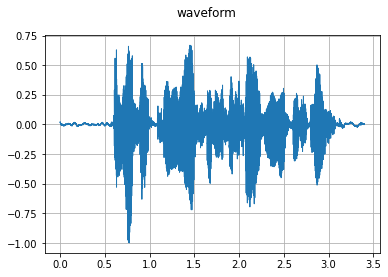

In [ ]:
plot_waveform(waveform, sample_rate)

### Plotting the audio `specgram`

In [ ]:
def plot_specgram(waveform, sample_rate, title="spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

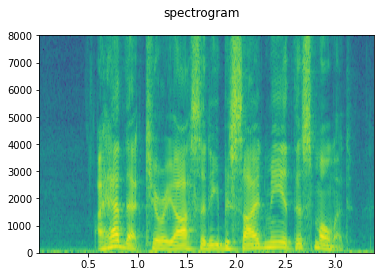

In [ ]:
plot_specgram(waveform, sample_rate)

### Playing the audio

In [ ]:
from IPython.display import Audio, display

In [ ]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
         display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:
play_audio(waveform, sample_rate)


### Playing a fake generated audio from random

In [ ]:
waveform.shape

torch.Size([1, 54400])

In [ ]:
wave_form = torch.rand((1, 54400), dtype=torch.float32)

In [ ]:
play_audio(wave_form, sample_rate)

### Loading from file-like object

torchaudio’s I/O functions now support file-like object. This allows to fetch audio data and decode at the same time from the location other than local file system.

### Load audio data as HTTP request

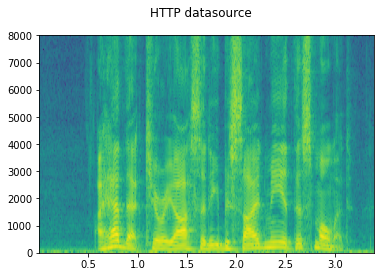

In [ ]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

### Load audio from tar file

In [ ]:
import tarfile

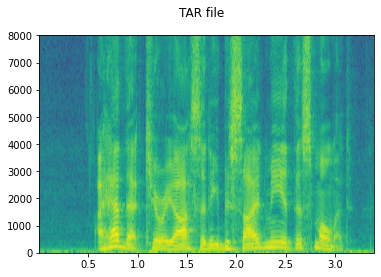

In [ ]:
# Load audio from tar file
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")


### Load audio from S3

In [ ]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

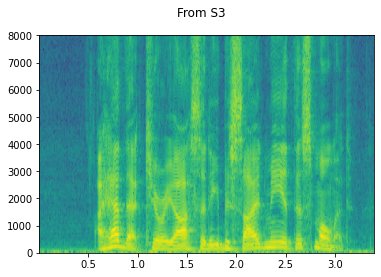

In [ ]:

# Load audio from S3
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title="From S3")

### Audio slicing

Providing `num_frames` and `frame_offset` arguments will slice the resulting Tensor object while decoding.

The same result can be achieved using the regular Tensor slicing, (i.e. ``waveform[:, frame_offset:frame_offset+num_frames]``) however, providing ``num_frames`` and ``frame_offset`` arguments is more efficient.

In [42]:
frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

print("Fetching all the data...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform1, sample_rate1 = torchaudio.load(response.raw)
  waveform1 = waveform1[:, frame_offset:frame_offset+num_frames]
  print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform2, sample_rate2 = torchaudio.load(
      response.raw, frame_offset=frame_offset, num_frames=num_frames)
  print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Fetching all the data...
 - Fetched 108844 bytes
Fetching until the requested frames are available...
 - Fetched 65580 bytes
Checking the resulting waveform ... matched!


### Saving audio to file

* To save an audio to a file we use the `torchadio.save`
* this function accepts path-like object and file-like object.

> When passing ``file-like`` object, you also need to provide ``format`` argument so that the function knows which ``format`` it should be using. In case of ``path-like`` object, the function will detemine the ``format`` based on the extension. If you are saving to a file without extension, you need to provide ``format`` argument.

When saving as WAV format, the default encoding for ``float32`` Tensor is 32-bit floating-point PCM. You can provide ``encoding`` and ``bits_per_sample`` argument to change this. For example, to save data in 16 bit signed integer PCM, you can do the following.

**Note:** Saving data in encodings with lower bit depth reduces the resulting file size but loses precision.



In [43]:
print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



### Save without any encoding option.
The function will pick up the encoding which the provided data fit.

In [48]:
def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

In [49]:
path = "save_example_default.wav"
torchaudio.save(path, waveform, sample_rate)

inspect_file(path)

----------
Source: save_example_default.wav
----------
 - File size: 217658 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)


In [50]:
wave_form, s_r = torchaudio.load(path)
play_audio(wave_form, s_r)

### Save as 16-bit signed integer Linear PCM
* The resulting file occupies half the storage but loses precision


In [51]:
path = "save_example_PCM_S16.wav"
torchaudio.save(
    path, waveform, sample_rate,
    encoding="PCM_S", bits_per_sample=16)
inspect_file(path)

----------
Source: save_example_PCM_S16.wav
----------
 - File size: 108844 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [52]:
wave_form, s_r = torchaudio.load(path)
play_audio(wave_form, s_r)

We can also specify the format that we want to save our audio in using the `torchaudio.save()` the following is an example on how we can save som of the audios in different fomarts.

In [54]:
formats = [
  "mp3",
  "flac",
  "vorbis",
  "sph",
  "amb",
  "amr-nb",
]

for format in formats:
  path = f"save_example.{format}"
  torchaudio.save(path, waveform, sample_rate, format=format)
  inspect_file(path)

----------
Source: save_example.mp3
----------
 - File size: 10476 bytes
 - AudioMetaData(sample_rate=16000, num_frames=55872, num_channels=1, bits_per_sample=0, encoding=MP3)
----------
Source: save_example.flac
----------
 - File size: 67552 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=24, encoding=FLAC)
----------
Source: save_example.vorbis
----------
 - File size: 19243 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=0, encoding=VORBIS)
----------
Source: save_example.sph
----------
 - File size: 218624 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_S)
----------
Source: save_example.amb
----------
 - File size: 217658 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)
----------
Source: save_example.amr-nb
----------
 - File size: 3852 bytes
 - AudioMetaData(sample_rate

###Saving to file-like object

Similar to the other I/O functions, you can save audio into file-like object. When saving to file-like object, ``format`` argument is required.



In [56]:
import io

In [57]:
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFF2R\x03\x00WAVEfmt '


### Resampling

* To resample an audio waveform from one freqeuncy to another, you can use ``transforms.Resample`` or ``functional.resample``.
* ``transforms.Resample`` precomputes and caches the kernel used for resampling, while ``functional.resample`` computes it on the fly, so using ``transforms.Resample`` will result in a speedup if resampling multiple waveforms using the same parameters.

In [64]:
import math
DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq
  
def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)




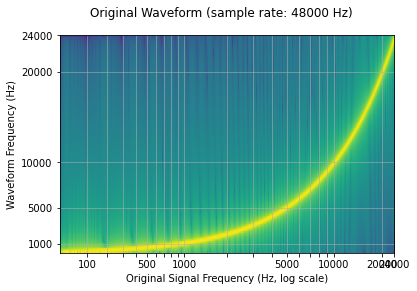

In [65]:
sample_rate = 48000
resample_rate = 32000
waveform = get_sine_sweep(sample_rate)
plot_sweep(waveform, sample_rate, title="Original Waveform")
play_audio(waveform, sample_rate)

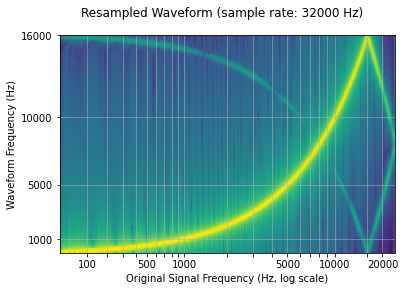

In [66]:
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)
plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
play_audio(waveform, sample_rate)

### Controling resampling quality with parameters

#### Lowpass filter width
Because the filter used for interpolation extends infinitely, the ``lowpass_filter_width`` parameter is used to control for the width of the filter to use to window the interpolation. It is also referred to as the number of zero crossings, since the interpolation passes through zero at every time unit. Using a larger ``lowpass_filter_width`` provides a sharper, more precise filter, but is more computationally expensive.

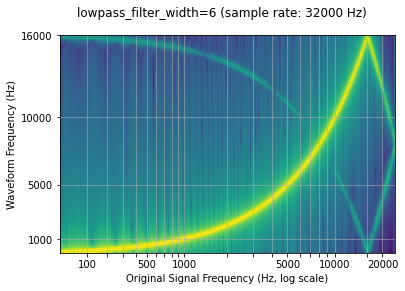

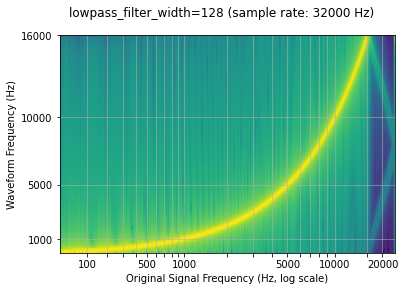

In [67]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

#### Rolloff

The ``rolloff`` parameter is represented as a fraction of the Nyquist frequency, which is the maximal frequency representable by a given finite sample rate. ``rolloff`` determines the lowpass filter cutoff and controls the degree of aliasing, which takes place when frequencies higher than the Nyquist are mapped to lower frequencies. A lower rolloff will therefore reduce the amount of aliasing, but it will also reduce some of the higher frequencies.

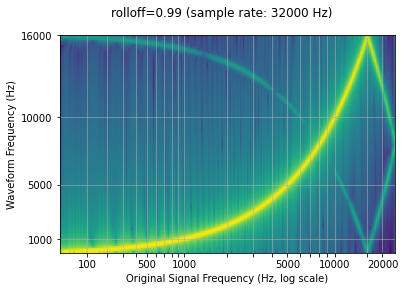

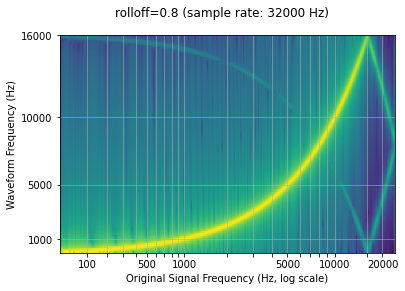

In [68]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

### The Window function

By default, torchaudio’s resample uses the Hann window filter, which is a weighted cosine function. It additionally supports the Kaiser window, which is a near optimal window function that contains an additional ``beta ``parameter that allows for the design of the smoothness of the filter and width of impulse. This can be controlled using the ``resampling_method`` parameter.

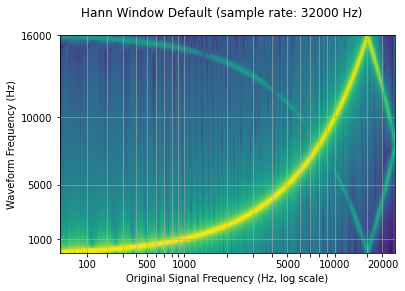

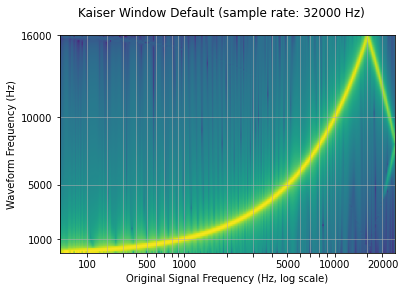

In [69]:
ample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

### Data Augumentation

### Applying effects and filtering
* ``torchaudio.sox_effects`` module provides ways to apply filiters like ``sox`` command on Tensor objects and file-object audio sources directly.

There are two functions for this;

* ``torchaudio.sox_effects.apply_effects_tensor`` for applying effects on Tensor
* ``torchaudio.sox_effects.apply_effects_file`` for applying effects on other audio source

For the list of available effects [read rge sox docs](http://sox.sourceforge.net/sox.html)

Tip If you need to load and resample your audio data on-the-fly, then you can use torchaudio.sox_effects.``apply_effects_file`` with ``"rate" `` effect.

**Note**: ``apply_effects_file`` accepts file-like object or path-like object. Similar to torchaudio.load, when the audio ``format`` cannot be detected from either file extension or header, you can provide ``format`` argument to tell what ``format`` the audio source is.

In [72]:
def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)
                     

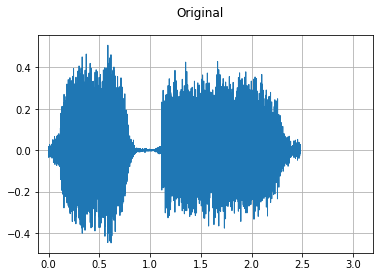

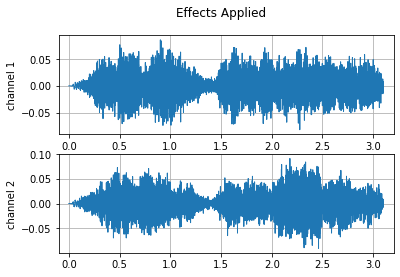

----------
Source: Original
----------
Sample Rate: 16000
Shape: (1, 39680)
Dtype: torch.float32
 - Max:      0.507
 - Min:     -0.448
 - Mean:    -0.000
 - Std Dev:  0.122

tensor([[ 0.0007,  0.0076,  0.0122,  ..., -0.0049, -0.0025,  0.0020]])

----------
Source: Effects Applied
----------
Sample Rate: 16000
Shape: (2, 49600)
Dtype: torch.float32
 - Max:      0.091
 - Min:     -0.091
 - Mean:    -0.000
 - Std Dev:  0.021

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0069, 0.0058, 0.0045],
        [0.0000, 0.0000, 0.0000,  ..., 0.0085, 0.0085, 0.0085]])



In [73]:
waveform1, sample_rate1 = get_sample(resample=16000)


# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate1}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    waveform1, sample_rate1, effects)

plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-.1, 3.2))
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-.1, 3.2))
print_stats(waveform1, sample_rate=sample_rate1, src="Original")
print_stats(waveform2, sample_rate=sample_rate2, src="Effects Applied")


Note that the number of frames and number of channels are different from the original after the effects. Let’s listen to the audio. Doesn’t it sound more dramatic?

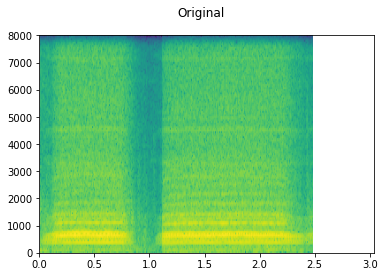

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


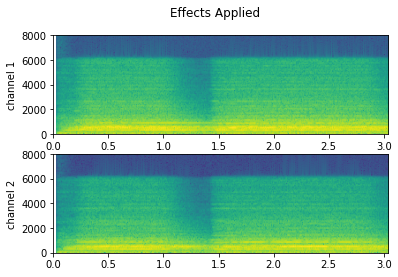

In [74]:
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
play_audio(waveform1, sample_rate1)
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
play_audio(waveform2, sample_rate2)

### Simulating room reverbration

[Convolution reverb](https://en.wikipedia.org/wiki/Convolution_reverb) is a technique used to make a clean audio data sound like in a different environment.

Using Room Impulse Response (RIR), we can make a clean speech sound like uttered in a conference room.

For this process, we need RIR data. The following data are from VOiCES dataset, but you can record one by your self. Just turn on microphone and clap you hands.

In [76]:
def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

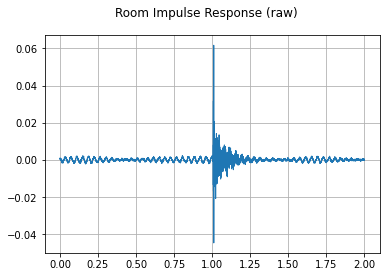

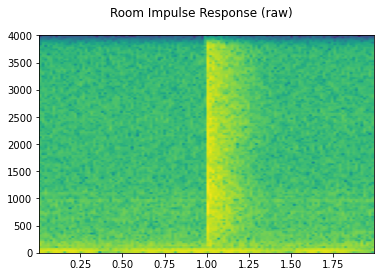

In [77]:
sample_rate = 8000

rir_raw, _ = get_rir_sample(resample=sample_rate)

plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
play_audio(rir_raw, sample_rate)

First, we need to clean up the RIR. We extract the main impulse, normalize the signal power, then flip the time axis.

Shape: (1, 2320)
Dtype: torch.float32
 - Max:      0.395
 - Min:     -0.286
 - Mean:    -0.000
 - Std Dev:  0.021

tensor([[-0.0052, -0.0076, -0.0071,  ...,  0.0184,  0.0173,  0.0070]])



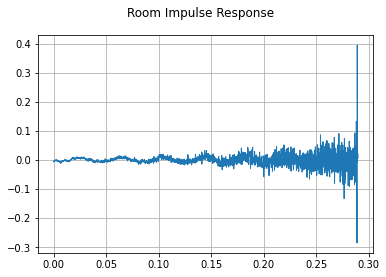

In [78]:
rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
rir = rir / torch.norm(rir, p=2)
rir = torch.flip(rir, [1])

print_stats(rir)
plot_waveform(rir, sample_rate, title="Room Impulse Response", ylim=None)

Then we convolve the speech signal with the RIR filter.

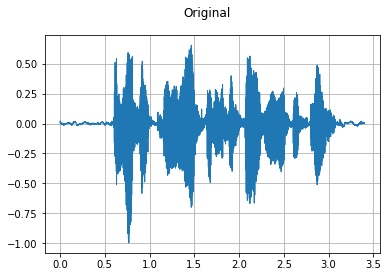

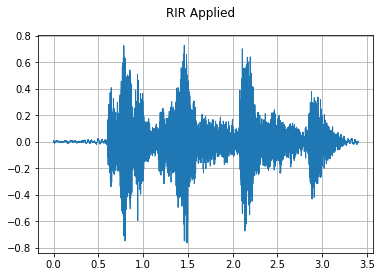

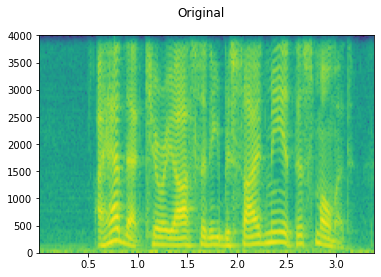

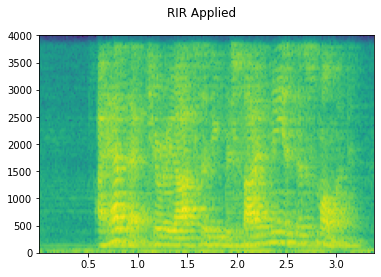

In [79]:
speech, _ = get_speech_sample(resample=sample_rate)

speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_waveform(speech, sample_rate, title="Original", ylim=None)
plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

plot_specgram(augmented, sample_rate, title="RIR Applied")
play_audio(augmented, sample_rate)

### Adding background noise

To add background noise to audio data, you can simply add audio Tensor and noise Tensor. A commonly way to adjust the intensity of noise is to change Signal-to-Noise Ratio (SNR). 


\begin{align}\mathrm{SNR} = \frac{P_\mathrm{signal}}{P_\mathrm{noise}}\end{align}

\begin{align}{\mathrm  {SNR_{{dB}}}}=10\log _{{10}}\left({\mathrm  {SNR}}\right)\end{align}


In [80]:
def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)


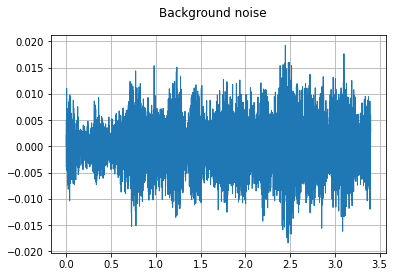

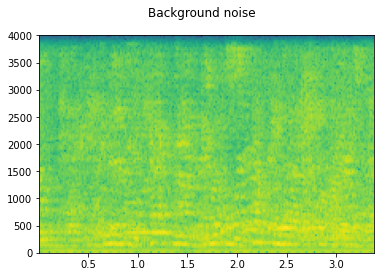

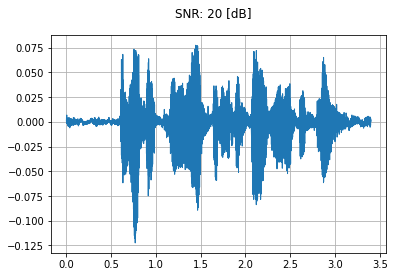

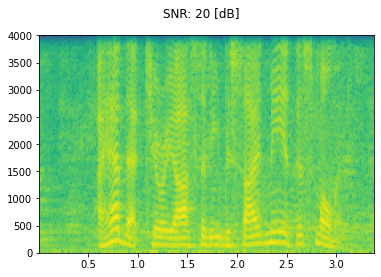

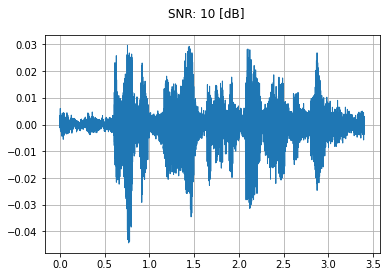

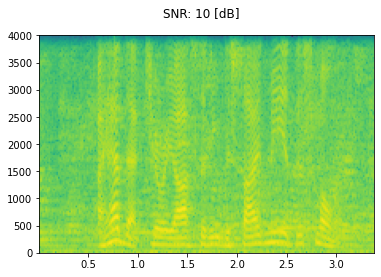

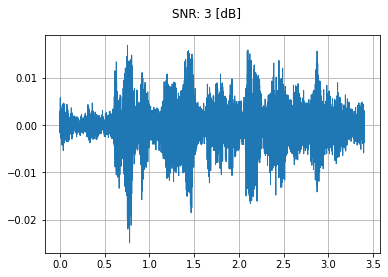

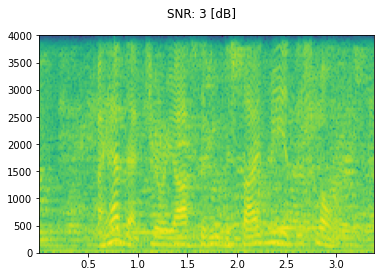

In [81]:
sample_rate = 8000
speech, _ = get_speech_sample(resample=sample_rate)
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
play_audio(noise, sample_rate)

speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)

for snr_db in [20, 10, 3]:
  snr = math.exp(snr_db / 10)
  scale = snr * noise_power / speech_power
  noisy_speech = (scale * speech + noise) / 2

  plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  play_audio(noisy_speech, sample_rate)

### Feature Extraction

``torchaudio`` implements feature extractions commonly used in audio domain. They are available in `` torchaudio.functional`` and ``torchaudio.transforms``.

* ``functional`` module implements features as a stand alone functions. They are stateless.

* ``transforms`` module implements features in object-oriented manner, using implementations from functional and ``torch.nn.Module``.

Because all the transforms are subclass of ``torch.nn.Module``, they can be serialized using TorchScript.

We will be looking at the (Spectrogram, GriffinLim, MelSpectrogram) and augmentation technique called SpecAugment, but the are more features in the documentation to look at.

### Spectrogram
To get the frequency representation of audio signal, you can use Spectrogram transform.

In [86]:
import librosa

In [87]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

Shape: (1, 513, 107)
Dtype: torch.float32
 - Max:     4000.533
 - Min:      0.000
 - Mean:     5.726
 - Std Dev: 70.301

tensor([[[7.8743e+00, 4.4462e+00, 5.6781e-01,  ..., 2.7694e+01,
          8.9546e+00, 4.1289e+00],
         [7.1094e+00, 3.2595e+00, 7.3520e-01,  ..., 1.7141e+01,
          4.4812e+00, 8.0840e-01],
         [3.8374e+00, 8.2490e-01, 3.0779e-01,  ..., 1.8502e+00,
          1.1777e-01, 1.2369e-01],
         ...,
         [3.4708e-07, 1.0604e-05, 1.2395e-05,  ..., 7.4090e-06,
          8.2063e-07, 1.0176e-05],
         [4.7173e-05, 4.4329e-07, 3.9444e-05,  ..., 3.0622e-05,
          3.9735e-07, 8.1572e-06],
         [1.3221e-04, 1.6440e-05, 7.2536e-05,  ..., 5.4662e-05,
          1.1663e-05, 2.5758e-06]]])



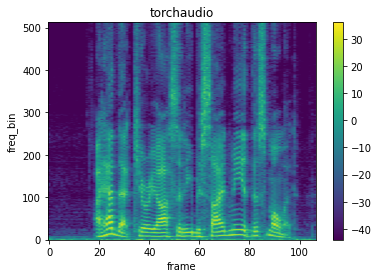

In [88]:
waveform, sample_rate = get_speech_sample()

n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

### GriffinLim

To recover a waveform from spectrogram, you can use GriffinLim.


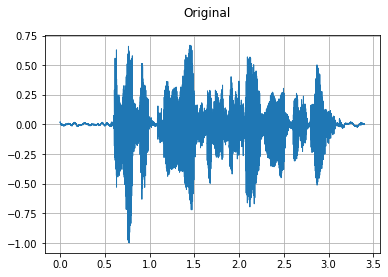

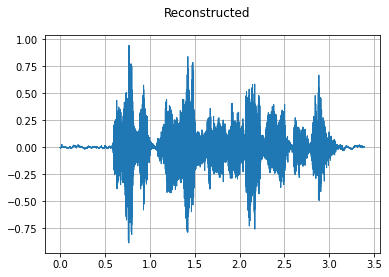

In [89]:
torch.random.manual_seed(0)
waveform, sample_rate = get_speech_sample()
plot_waveform(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)
waveform = griffin_lim(spec)

plot_waveform(waveform, sample_rate, title="Reconstructed")
play_audio(waveform, sample_rate)

### Mel Filter Bank

``torchaudio.functional.create_fb_matrix`` can generate the filter bank to convert frequency bins to Mel-scale bins.

Since this function does not require input audio/features, there is no equivalent transform in ``torchaudio.transforms``.


In [90]:
def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

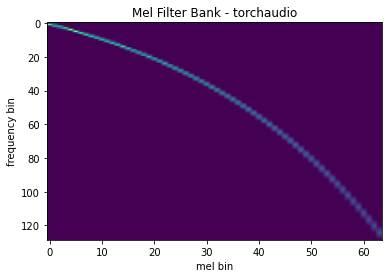

In [91]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.create_fb_matrix(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.,
    f_max=sample_rate/2.,
    sample_rate=sample_rate,
    norm='slaney'
)
plot_mel_fbank(mel_filters, "Mel Filter Bank - torchaudio")

### Datasets 

torchaudio provides easy access to common, publicly accessible datasets. Please checkout the official documentation for the list of available datasets.

Here, we take YESNO dataset and look into how to use it.


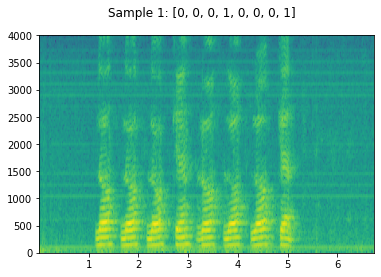

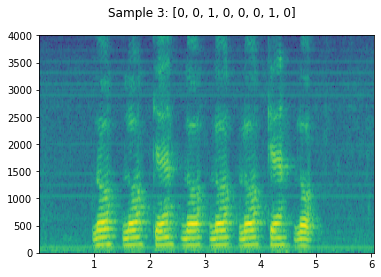

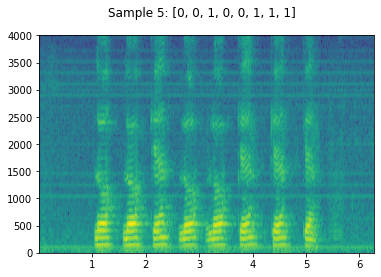

In [92]:
YESNO_DOWNLOAD_PROCESS.join()

dataset = torchaudio.datasets.YESNO(YESNO_DATASET_PATH, download=True)

for i in [1, 3, 5]:
  waveform, sample_rate, label = dataset[i]
  plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
  play_audio(waveform, sample_rate)

### Conclusion

This tutorial covers a lot of ground on `touchadio` and audio proccessing and manipulation.


### References

1. [audio_preprocessing_tutorial](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)
2. [Docs](https://pytorch.org/audio/stable/torchaudio.html)